In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

from LSSVMRegression import LSSVMRegression

from windTransformer import WindVectorTransformer
from windTransformer import WindDegreeTransformer
from windData import WindDataCollector

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd

from influxdb import InfluxDBClient # install via "pip install influxdb"

import datetime

In [2]:
def eval_metrics(actual, pred):
	rmse = np.sqrt(mean_squared_error(actual, pred))
	mae = mean_absolute_error(actual, pred)
	r2 = r2_score(actual, pred)
	return rmse, mae, r2


## Data prep

In [3]:
start_time = datetime.datetime(2021, 1, 1, 0, 0, 0).strftime("'%Y-%m-%dT%H:%M:%SZ'")


dataCollector = WindDataCollector()

gen_df = dataCollector.getGenerationData(now = start_time, delta="90")
wind_df = dataCollector.getWindData(now = start_time, delta="90")

gen_df_alligned = pd.merge_asof(wind_df,gen_df,left_index=True, right_index=True)

In [4]:
train_length = int(len(gen_df_alligned)*0.9)

train_X = gen_df_alligned.iloc[:train_length][[
#    "Direction",
    "Speed"]]
test_X = gen_df_alligned.iloc[train_length:][[
#    "Direction",
    "Speed"]]

train_y = gen_df_alligned.iloc[:train_length]["Total"]
test_y = gen_df_alligned.iloc[train_length:]["Total"]

In [5]:
import plotly.express as px


fig = px.scatter(gen_df_alligned, x="Speed", y="Total")
fig.show()

## Support Vector Machines CAAP

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

### Linear Kernel

In [6]:
pipeline = Pipeline(steps=[
	("svm_model", svm.SVR())
])
parameters = {
    'svm_model__kernel':["linear"],
    'svm_model__C':[0.001, 0.01, 0.1, 1, 10, 100],
    'svm_model__gamma':["auto"]
}

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
pipeline = GridSearchCV(pipeline, param_grid=parameters, n_jobs=15, cv= tscv,scoring="r2")

svr_lin = pipeline.fit(train_X, np.ravel(train_y))

bestParams = pipeline.best_params_

predicted_qualities = pipeline.best_estimator_.predict(test_X)

#svm_rbf = pd.DataFrame(pipeline.cv_results_)[["mean_fit_time","mean_test_score","param_svm_model__gamma"]]

(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("SVR model (gamma={}, kernel={}, C={})".format(bestParams["svm_model__gamma"], bestParams["svm_model__kernel"], bestParams["svm_model__C"]))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

SVR model (gamma=auto, kernel=linear, C=0.1)
  RMSE: 5.3185935631313
  MAE: 3.935263166431311
  R2: 0.8306961771508213


### RBF Kernel

In [8]:
pipeline = Pipeline(steps=[
	("svm_model", svm.SVR())
])
parameters = {
    'svm_model__kernel':["rbf"],
    'svm_model__C':[0.001, 0.01, 0.1, 1, 10, 100],
    'svm_model__gamma':["scale"],
    'svm_model__epsilon':[0.001, 0.01, 0.1, 1]
}

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
pipeline = GridSearchCV(pipeline, param_grid=parameters, n_jobs=15, cv= tscv,scoring="r2")

svr_rbf = pipeline.fit(train_X, np.ravel(train_y))

bestParams = pipeline.best_params_

predicted_qualities = pipeline.best_estimator_.predict(test_X)

#svm_rbf = pd.DataFrame(pipeline.cv_results_)[["mean_fit_time","mean_test_score","param_svm_model__gamma"]]

(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("SVR model (gamma={}, kernel={}, C={})".format(bestParams["svm_model__gamma"], bestParams["svm_model__kernel"], bestParams["svm_model__C"]))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

SVR model (gamma=scale, kernel=rbf, C=100)
  RMSE: 3.914815998512096
  MAE: 3.1781748596198964
  R2: 0.9082732795622529


### Poly Kernel

In [10]:
pipeline = Pipeline(steps=[
	("svm_model", svm.SVR())
])
parameters = {
    'svm_model__kernel':["poly"],
    'svm_model__C':[0.001, 0.01, 0.1, 1, 10, 100],
    'svm_model__degree':[3]
}

In [11]:
tscv = TimeSeriesSplit(n_splits=5)
pipeline = GridSearchCV(pipeline, param_grid=parameters, n_jobs=15, cv= tscv,scoring="r2")

svr_poly = pipeline.fit(train_X, np.ravel(train_y))

bestParams = pipeline.best_params_

predicted_qualities = pipeline.best_estimator_.predict(test_X)

#svm_poly = pd.DataFrame(pipeline.cv_results_)[["mean_fit_time","mean_test_score","param_svm_model__C"]]

(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print(bestParams)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

{'svm_model__C': 0.001, 'svm_model__degree': 3, 'svm_model__kernel': 'poly'}
  RMSE: 8.045137736998258
  MAE: 6.750063595813313
  R2: 0.6126173863800095


In [31]:
svr = svr_poly.best_estimator_[0]

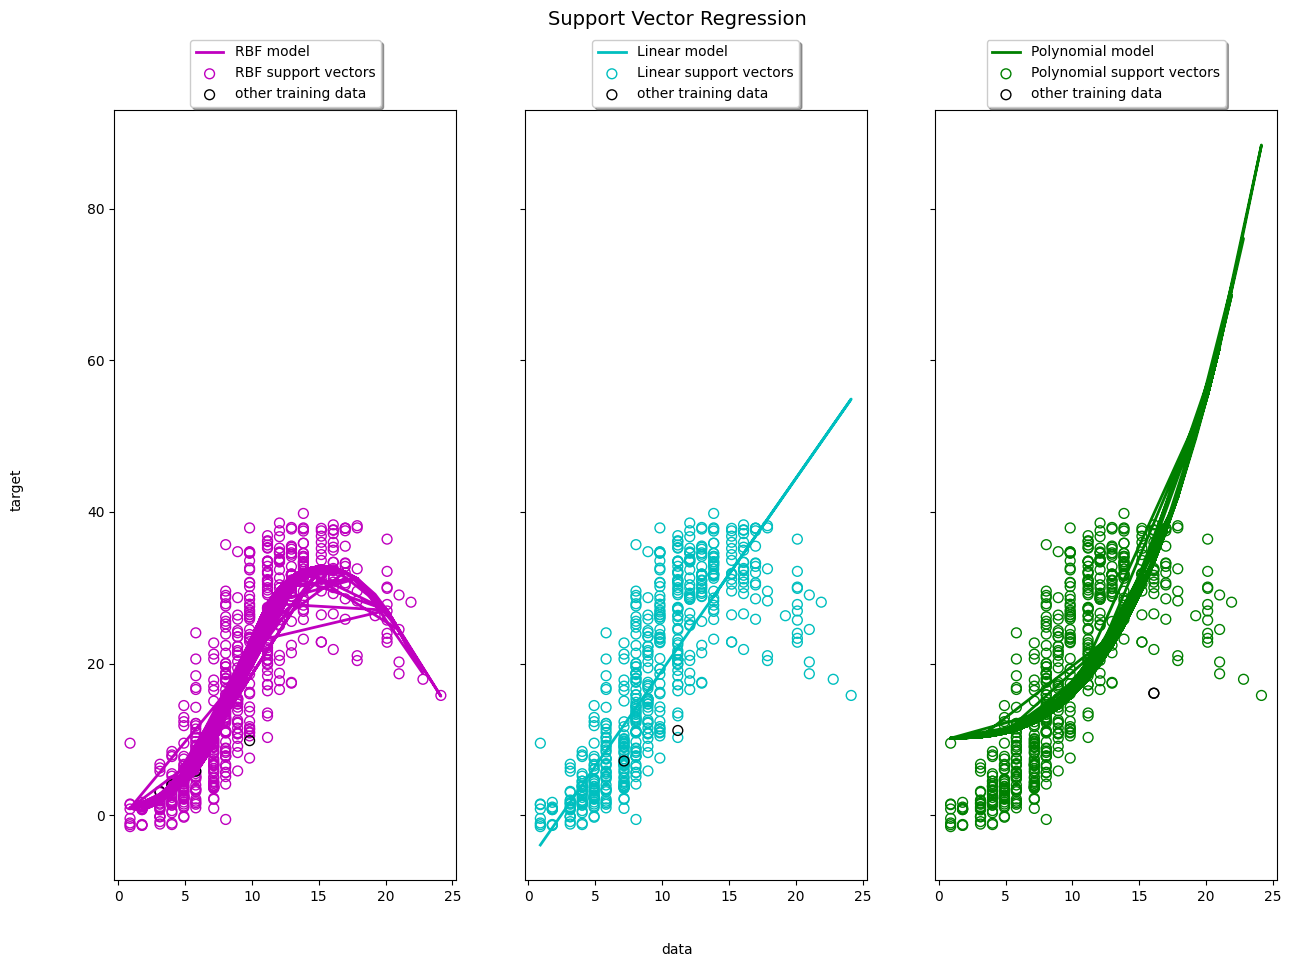

In [33]:
lw = 2
svrs = [svr_rbf.best_estimator_[-1], svr_lin.best_estimator_[-1], svr_poly.best_estimator_[-1]]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        train_X["Speed"],
        svr.predict(train_X),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        train_X["Speed"][svr.support_],
        train_y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        train_X["Speed"][np.setdiff1d(np.arange(len(train_X["Speed"])), svr.support_)],
        train_X["Speed"][np.setdiff1d(np.arange(len(train_X["Speed"])), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()